In [1]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from IPython import display
rs = (96,96)

In [2]:
def read_images_bulk(dataset_path, grayscale=False):
    imgs, labels = list(), list()
    # An ID will be affected to each sub-folders by alphabetical order
    label = 0
    # List the directory
    classes = sorted(os.walk(dataset_path).next()[1])
    # List each sub-directory (the classes)
    for c in classes:
        c_dir = os.path.join(dataset_path, c)
        walk = os.walk(c_dir).next()
        # Add each image to the training set
        for sample in walk[2]:
            # Only keeps jpeg images
            if sample.endswith('.jpg') or sample.endswith('.jpeg'):
                if grayscale:
                    imgs.append(cv2.imread(os.path.join(c_dir, sample),0))
                else:
                    img = cv2.imread(os.path.join(c_dir, sample))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    imgs.append(img)
                labels.append(label)
        label += 1
    return np.array(imgs), np.array(labels)

def load_img_and_transform(path, grayscale=True, rsize=(96,96), flattern=False):
    def _normalize(img):
        mn, sd = cv2.meanStdDev(img)
        mn = mn[0][0]
        sd = sd[0][0]
        img = (img - mn) / sd
        return img
    
    imgs, labels = read_images_bulk(path, grayscale=grayscale)
    untrs_img, _ = read_images_bulk(path, grayscale=False)
    imgs = map(lambda x: cv2.resize(x, rs, interpolation = cv2.INTER_CUBIC), imgs)
    imgs = map(lambda x: x.flatten(), imgs)
    imgs = np.array(imgs)
    return imgs, labels, untrs_img

def load_img_and_transform_single(path, grayscale=True, rsize=(96,96), flattern=False):
    def _normalize(img):
        mn, sd = cv2.meanStdDev(img)
        mn = mn[0][0]
        sd = sd[0][0]
        img = (img - mn) / sd
        return img
    
    untrs_img = cv2.imread(os.path.join(path))
    untrs_img = cv2.cvtColor(untrs_img, cv2.COLOR_BGR2RGB)
    img = untrs_img
    if grayscale:
        img = cv2.imread(os.path.join(path),0)
        
    img = cv2.resize(img, rsize, interpolation = cv2.INTER_CUBIC)
    img = img.flatten()
    return img, untrs_img

def show_images_from_ds(ds, index):
    img = ds[index]
    _ = plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    _ = plt.xticks([]), plt.yticks([])
    
def rotate_3x(ds, label):
    def rotate(img, angle):
        (h, w) = img.shape[:2]
        center = (w / 2, h / 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(img, M, (w, h))
        return rotated
    angles = [90, 45,180,105,270]
    label = list(label)
    newds = list()
    newds += ds
    for ang in angles:
        newds += [rotate(x, ang) for x in ds]
    label = label + label + label + label + label + label
    return np.array(newds), np.array(label)

In [3]:
def trf_label(label):
    if label == 0:
        return np.array([1,0])
    if label == 1:
        return np.array([0,1])
    return np.array([0,0])

def transform_img_for_input(imgs, rs=(96,96)):
    if isinstance(imgs, list) or isinstance(imgs, np.ndarray):
        imgs = map(lambda x: cv2.resize(x, rs, interpolation = cv2.INTER_CUBIC), imgs)
        imgs = map(lambda x: x.flatten(), imgs)
        imgs = np.array(imgs)
    else:
        imgs = cv2.resize(imgs, rs, interpolation = cv2.INTER_CUBIC)
        imgs = imgs.flatten()
    return imgs

g = True
ramremds, labels = read_images_bulk("train_img_anime/", grayscale=g)

## get ram and rem data only
ramremds = ramremds[map(lambda x: x in (0,1),labels)]
labels = labels[map(lambda x: x in (0,1),labels)]

ramremrescale = map(lambda x: cv2.resize(x, rs, interpolation = cv2.INTER_CUBIC), ramremds)
ds_final, labels_final = rotate_3x(ramremrescale, labels)
ds_final_f = transform_img_for_input(ds_final)
labels_final = np.array([trf_label(x) for x in labels_final])

print len(ds_final)
print len(labels_final)
type(ds_final_f)

1080
1080


numpy.ndarray

## Let see our image

[0, 1]


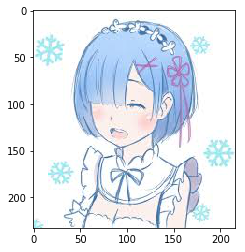

In [22]:
img_n = 87
ramremds, labels = read_images_bulk("train_img_anime/", grayscale=False)
## get ram and rem data only
ramremds = ramremds[map(lambda x: x in (0,2),labels)]
labels = labels[map(lambda x: x in (0,2),labels)]
labels = [([1,0] if x == 0 else [0,1]) for x in labels]
print labels[img_n]
plt.imshow(ramremds[img_n])

input : REM


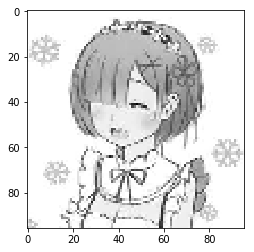

In [24]:
plt.imshow(ds_final_f[img_n].reshape(96,96), cmap='gray')
print 'input : RAM' if labels[img_n][0] == 1 else 'input : REM'

In [35]:
ds_final_f[img_n].reshape(96,96)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ..., 
       [227, 211, 218, ..., 255, 255, 255],
       [242, 232, 255, ..., 255, 255, 255],
       [213, 224, 209, ..., 255, 255, 255]], dtype=uint8)

# Tensor Flow

In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [27]:
# Training Parameters
learning_rate = 0.001
num_steps = 500
num_batch = 15
display_step = 10

# Network Parameters
num_input = len(ds_final_f[0]) # num data input
num_classes = 2 # Total num class
dropout = 0.75 # Dropout, probability to keep units
print num_input

ds_x_mini = np.array_split(ds_final_f, num_batch)
ds_y_mini = np.array_split(labels_final, num_batch)

print map(lambda x: len(x), ds_x_mini)

9216
[72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72]


In [28]:
x_test, y_test = read_images_bulk("test_ramrem_only/", grayscale=g)
x_test = transform_img_for_input(x_test, rs=(96,96))
y_test = [([1,0] if x == 0 else [0,1]) for x in y_test]

x_test_c, _ = read_images_bulk("test_ramrem_only/", grayscale=False)

In [29]:
rs = (96,96)

#reset default graph
tf.reset_default_graph()

# define a graph
graph1 = tf.Graph()

with graph1.as_default():
    # tf Graph input
    X = tf.placeholder(tf.float32, [None, num_input], name="X")
    Y = tf.placeholder(tf.float32, [None, num_classes], name="Y")
    keep_prob = tf.placeholder(tf.float32, name="keep_prob") # dropout (keep probability)
    reduced_size = rs[0]/4

    # Store layers weight & bias
    weights = {
        # 5x5 conv, 1 input, 32 outputs
        'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
        # 5x5 conv, 32 inputs, 64 outputs
        'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
        # fully connected, 32*32*64 inputs, 1024 outputs (1/4 dari input)
        'wd1': tf.Variable(tf.random_normal([reduced_size*reduced_size*64, 1024])),
        # 1024 inputs, 10 outputs (class prediction)
        'out': tf.Variable(tf.random_normal([1024, num_classes]))
    }

    biases = {
        'bc1': tf.Variable(tf.random_normal([32])),
        'bc2': tf.Variable(tf.random_normal([64])),
        'bd1': tf.Variable(tf.random_normal([1024])),
        'out': tf.Variable(tf.random_normal([num_classes]))
    }
    
    def model(x, weights, biases, dropout):
        ## Reshape to match input
        x = tf.reshape(x, shape=[-1, 96, 96, 1]) #==> -1 num batch, 
        x = tf.map_fn(lambda x: tf.image.per_image_standardization(x), x)
        
        ## First Conv Layer
        strides = 1
        x = tf.nn.conv2d(x, weights['wc1'], strides=[1, strides, strides, 1], padding='SAME')
        x = tf.nn.bias_add(x, biases['bc1'])
        x = tf.nn.relu(x)
        ## Max Pooling to reduce dimentionality
        k = 2
        x = tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')
        
        ## Second Conv Layer
        x = tf.nn.conv2d(x, weights['wc2'], strides=[1, strides, strides, 1], padding='SAME')
        x = tf.nn.bias_add(x, biases['bc2'])
        x = tf.nn.relu(x)
        ## Max Pooling
        x = tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')
        
        # Fully connected layer
        x = tf.reshape(x, [-1, weights['wd1'].get_shape().as_list()[0]])
        x = tf.add(tf.matmul(x, weights['wd1']), biases['bd1'])
        x = tf.nn.relu(x)
        # Apply Dropout
        x = tf.nn.dropout(x, dropout)
        
        # Output, class prediction
        out = tf.add(tf.matmul(x, weights['out']), biases['out'], name="f_convnet_logit")
        return out
    
    # Construct model
    logits = model(X, weights, biases, keep_prob)
    prediction = tf.nn.softmax(logits, name="f_prediction")

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=Y), name="lost_op")
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name="f_adam_optimizer")
    train_op = optimizer.minimize(loss_op, name="f_train_op")


    # Evaluate model
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1), name="f_correct_pred")
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name="f_accuracy")
    
    # Start training
    saver = tf.train.Saver()

In [125]:
test_acc_all = list()
train_acc_all = list()
steps = range(1, num_steps+1)

with tf.Session(graph=graph1) as sess:

    # Run the initializer
    sess.run(tf.global_variables_initializer())
    batch_n = 0
    for step in steps:
        batch_x, batch_y = ds_x_mini[batch_n], ds_y_mini[batch_n]
        batch_n += 1
        if batch_n >= num_batch:
            batch_n = 0
        
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y,
                                                                 keep_prob: 1.0})
            
            acc_test = sess.run(accuracy, feed_dict={X: x_test, Y: y_test, keep_prob: 1.0})
            acc_train = sess.run(accuracy, feed_dict={X: ds_final_f, Y: labels_final, keep_prob: 1.0})
            test_acc_all.append(acc_test)
            train_acc_all.append(acc_train)
            
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc) + ", Test Accuracy = " + "{:.3f}".format(acc_test))

    print("Optimization Finished!")
    
    # Save model weights to disk
    save_path = saver.save(sess, "./ramrem_simple_clasifier/model.ckpt")
    print("Model saved in file: %s" % save_path)

Step 1, Minibatch Loss= 0.0000, Training Accuracy= 1.000, Test Accuracy = 0.512
Step 10, Minibatch Loss= 120332.7188, Training Accuracy= 0.500, Test Accuracy = 0.683
Step 20, Minibatch Loss= 11102.1045, Training Accuracy= 0.944, Test Accuracy = 0.634
Step 30, Minibatch Loss= 230205.2188, Training Accuracy= 0.236, Test Accuracy = 0.585
Step 40, Minibatch Loss= 1760.9231, Training Accuracy= 0.986, Test Accuracy = 0.512
Step 50, Minibatch Loss= 587763.5625, Training Accuracy= 0.000, Test Accuracy = 0.512
Step 60, Minibatch Loss= 708.0469, Training Accuracy= 0.986, Test Accuracy = 0.488
Step 70, Minibatch Loss= 997942.1250, Training Accuracy= 0.000, Test Accuracy = 0.512
Step 80, Minibatch Loss= 492.5310, Training Accuracy= 0.986, Test Accuracy = 0.585
Step 90, Minibatch Loss= 293101.1250, Training Accuracy= 0.194, Test Accuracy = 0.585
Step 100, Minibatch Loss= 0.0000, Training Accuracy= 1.000, Test Accuracy = 0.561
Step 110, Minibatch Loss= 96029.7344, Training Accuracy= 0.458, Test Accu

In [28]:
num_steps = 100
test_acc_all = list()
train_acc_all = list()
steps = range(1, num_steps+1)
#reset default graph
tf.reset_default_graph()
saver = tf.train.import_meta_graph('./ramrem_simple_clasifier/model.ckpt.meta')
save_path = './ramrem_simple_clasifier/'

with tf.Session(graph=graph1) as sess:

    saver.restore(sess,tf.train.latest_checkpoint('./ramrem_simple_clasifier/'))
    print("Model restored from file: %s" % save_path)
    
    batch_n = 0
    for step in steps:
        batch_x, batch_y = ds_x_mini[batch_n], ds_y_mini[batch_n]
        batch_n += 1
        if batch_n >= num_batch:
            batch_n = 0
        
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y,
                                                                 keep_prob: 1.0})
            
            acc_test = sess.run(accuracy, feed_dict={X: x_test, Y: y_test, keep_prob: 1.0})
            acc_train = sess.run(accuracy, feed_dict={X: ds_final_f, Y: labels_final, keep_prob: 1.0})
            test_acc_all.append(acc_test)
            train_acc_all.append(acc_train)
            
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc) + ", Test Accuracy = " + "{:.3f}".format(acc_test))

    print("Optimization Finished!")
    
    # Save model weights to disk
    save_path = saver.save(sess, "./ramrem_simple_clasifier/model.ckpt")
    print("Model saved in file: %s" % save_path)

INFO:tensorflow:Restoring parameters from ./ramrem_simple_clasifier/model.ckpt
Model restored from file: ./ramrem_simple_clasifier/
Step 1, Minibatch Loss= 0.0000, Training Accuracy= 1.000, Test Accuracy = 0.780
Step 10, Minibatch Loss= 0.0000, Training Accuracy= 1.000, Test Accuracy = 0.805
Step 20, Minibatch Loss= 0.0000, Training Accuracy= 1.000, Test Accuracy = 0.829
Step 30, Minibatch Loss= 697.3396, Training Accuracy= 0.986, Test Accuracy = 0.805
Step 40, Minibatch Loss= 0.0000, Training Accuracy= 1.000, Test Accuracy = 0.829
Step 50, Minibatch Loss= 580.3301, Training Accuracy= 0.986, Test Accuracy = 0.805
Step 60, Minibatch Loss= 0.0000, Training Accuracy= 1.000, Test Accuracy = 0.854
Step 70, Minibatch Loss= 4357.6118, Training Accuracy= 0.861, Test Accuracy = 0.805
Step 80, Minibatch Loss= 0.0000, Training Accuracy= 1.000, Test Accuracy = 0.780
Step 90, Minibatch Loss= 6917.9863, Training Accuracy= 0.819, Test Accuracy = 0.683
Step 100, Minibatch Loss= 0.0000, Training Accura

In [29]:
print "Training Accuracy : {}".format(train_acc_all[-1])
print "Testing Accuracy : {}".format(test_acc_all[-1])

Training Accuracy : 0.873148143291
Testing Accuracy : 0.829268276691


# Test the model

In [30]:
x_test, y_test = read_images_bulk("test_ramrem_only/", grayscale=g)
x_test = transform_img_for_input(x_test, rs=(96,96))
y_test = [([1,0] if x == 0 else [0,1]) for x in y_test]

x_test_c, _ = read_images_bulk("test_ramrem_only/", grayscale=False)

[1, 0]


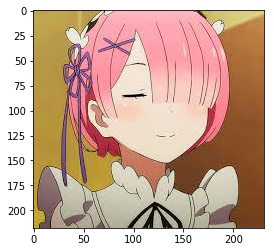

In [31]:
## 0 tuh siapa yaks
plt.imshow(x_test_c[0])
print y_test[0]

In [32]:
#reset default graph
tf.reset_default_graph()
saver = tf.train.import_meta_graph('./ramrem_simple_clasifier/model.ckpt.meta')

with tf.Session(graph=graph1) as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess,tf.train.latest_checkpoint('./ramrem_simple_clasifier/'))
    pr = sess.run(prediction, feed_dict={X: x_test, keep_prob: 1.0})
    
    # Calculate accuracy for 256 MNIST test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: x_test,
                                      Y: y_test,
                                      keep_prob: 1.0}))

INFO:tensorflow:Restoring parameters from ./ramrem_simple_clasifier/model.ckpt
('Testing Accuracy:', 0.82926828)


RAM
[ 1.  0.]


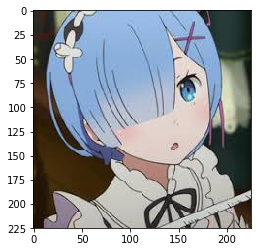

In [33]:
n = 37
ax = plt.imshow(x_test_c[n])
print "RAM" if pr[n][0] == 1 else "REM"
print (pr[n])

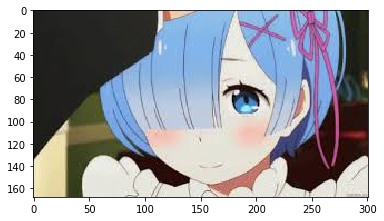

REM
[ 0.  1.]


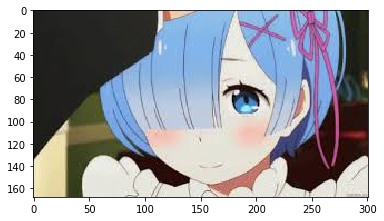

In [34]:
from random import shuffle
import time
rn_list = range(len(pr))
shuffle(rn_list)

for n in rn_list:
    ax = plt.imshow(x_test_c[n])
    display.clear_output(wait=True)
    display.display(ax.figure)
    print "RAM" if pr[n][0] == 1 else "REM"
    print (pr[n])
    time.sleep(3)

# Basic

In [8]:
%matplotlib inline
# Load an color image in grayscale
img = cv2.imread('train_img_anime/ram/1.jpg',0)

In [5]:
cv2.imshow('image',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

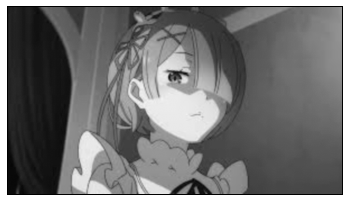

In [10]:
_ = plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
_ = plt.xticks([]), plt.yticks([])

In [9]:
tf.GraphKeys.GLOBAL_VARIABLES

'variables'

[<tf.Variable 'Variable:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(36864, 1024) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(1024, 2) dtype=float32_ref>,
 <tf.Variable 'Variable_4:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Variable_5:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'Variable_6:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'Variable_7:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'Variable/Adam:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'Variable/Adam_1:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'Variable_1/Adam:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'Variable_1/Adam_1:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'Variable_2/Adam:0' shape=(36864, 1024) dtype=float32_

In [ ]:
tf.get